# Anime Recommedation

## Overview

## Business Problem

I am working with a client who is a business that wants to recommend anime to someone who already watches anime.

## Data Source

[My Anime List](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020/discussion?sort=hotness)

## Results

## Importing

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

import random

## Data Read In

In [15]:
#17562 different anime
anime = pd.read_csv("data/MyAnimeList/anime.csv")

In [16]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

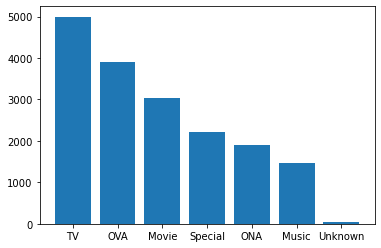

TV         4996
OVA        3894
Movie      3041
Special    2218
ONA        1907
Music      1469
Unknown      37
Name: Type, dtype: int64

In [17]:
plt.bar(anime["Type"].value_counts().index, anime["Type"].value_counts())
plt.show()
anime["Type"].value_counts()

In [18]:
#Only keep television shows, movies and original net animation (a television show only released on a streaming service)
anime = anime.loc[anime["Type"].isin(["TV", "Movie", "ONA"])]

In [19]:
anime["Score"].value_counts()

Unknown    3006
6.52         47
6.45         47
7.28         42
6.6          42
           ... 
4.2           1
8.82          1
9.17          1
4.26          1
2.63          1
Name: Score, Length: 517, dtype: int64

In [20]:
#remove scores of anime that are unknown
anime = anime.loc[anime["Score"] != "Unknown"]

In [21]:
anime["Type"].value_counts()

TV       3837
Movie    2017
ONA      1084
Name: Type, dtype: int64

In [22]:
#anime = anime.loc[anime["Premiered"] != "Unknown"]

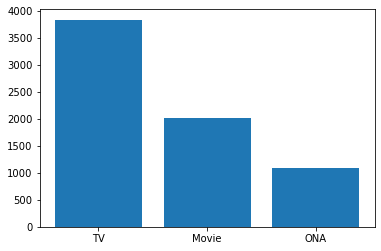

TV       3837
Movie    2017
ONA      1084
Name: Type, dtype: int64

In [23]:
plt.bar(anime["Type"].value_counts().index, anime["Type"].value_counts())
plt.show()
anime["Type"].value_counts()

In [24]:
#new column to split Aired column up to get the anime's airing year
anime["Aired_Split"] = [aired.split() for aired in anime["Aired"]]
anime["Aired_Split"]
started_airing = []
#since the aired column is written in different ways, we must use an if statement to find the corresponding year in the split
for row in anime["Aired_Split"]:
    if len(row) == 1:
        started_airing.append(row[0])
    elif len(row) == 2:
        started_airing.append(row[1])
    else:
        if row[2] == "to":
            started_airing.append(row[1])
        elif row[2] == "?":
            started_airing.append(row[0])
        else:
            started_airing.append(row[2])
#new column to track anime's airing year
anime["Aired_Year"] = started_airing
#remove two unknown aired years
anime = anime.loc[anime["Aired_Year"] != "Unknown"]
anime["Aired_Year"] = anime["Aired_Year"].astype(int)

In [25]:
#Removed animes that premiered in the year 2020 as the database is from February 2020
#Anime released would either not be out or not have enough reviews at that point
anime = anime.loc[anime["Aired_Year"] < 2020]
anime

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Aired_Split,Aired_Year
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"[Sep, 1,, 2001]",2001
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"[Apr, 1,, 1998, to, Sep, 30,, 1998]",1998
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,"[Jul, 2,, 2002, to, Dec, 24,, 2002]",2002
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,"[Sep, 30,, 2004, to, Sep, 29,, 2005]",2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17170,42913,Saezuru Doubutsu wa Yarushikanai!,6.45,Comedy,Unknown,囀る動物はやるしかない！,ONA,30,"Dec 19, 2019 to Aug 28, 2020",Unknown,...,25.0,58.0,52.0,31.0,12.0,5.0,3.0,3.0,"[Dec, 19,, 2019, to, Aug, 28,, 2020]",2019
17200,42985,Ling Long: Incarnation Middle Chapter,7.07,"Action, Sci-Fi, Horror, Demons, Drama, Thriller",Ling Cage,灵笼:INCARNATION 中章,ONA,1,"Nov 17, 2019",Unknown,...,33.0,37.0,16.0,6.0,3.0,2.0,1.0,4.0,"[Nov, 17,, 2019]",2019
17313,43779,Eoneu Nal Jameseo Kkaeeoboni Bagelyeoga Doeeo ...,6.58,"Comedy, Romance, Ecchi",Unknown,어느 날 잠에서 깨어보니 베이글녀가 되어 있었다,ONA,15,"Nov 25, 2019 to Dec 2, 2019",Unknown,...,123.0,235.0,174.0,89.0,43.0,17.0,12.0,14.0,"[Nov, 25,, 2019, to, Dec, 2,, 2019]",2019
17319,43878,Miko no Tsutome!,6.46,Comedy,Unknown,みこのつとめっ！,ONA,10,"Dec 7, 2018 to Feb 8, 2019",Unknown,...,15.0,33.0,27.0,29.0,3.0,3.0,2.0,14.0,"[Dec, 7,, 2018, to, Feb, 8,, 2019]",2018


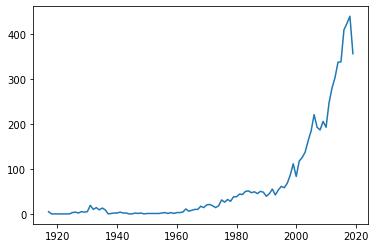

1917      6
1918      1
1924      1
1925      4
1926      5
       ... 
2015    338
2016    409
2017    423
2018    439
2019    356
Name: Aired_Year, Length: 95, dtype: int64

In [26]:
plt.plot(anime["Aired_Year"].value_counts().sort_index())
plt.show()
anime["Aired_Year"].value_counts().sort_index()

In [27]:
#read in users and their reviews
ratings = pd.read_csv("data/MyAnimeList/animelist.csv")
ratings

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0
...,...,...,...,...,...
109224742,353404,507,7,2,2
109224743,353404,392,9,2,112
109224744,353404,882,6,2,1
109224745,353404,883,8,2,1


In [28]:
#gets a random sample of 20,000 different users
random_users = list(ratings["user_id"].drop_duplicates().sample(n=20000, random_state=42).values)
ratings = ratings.loc[ratings["user_id"].isin(random_users)]
ratings

#I believe that a rating of 0 means that its not currently rated by the user.
#I might need to decide if I remove them entirely

,user_id,anime_id,rating,watching_status,watched_episodes
213,2,24833,0,1,0
214,2,235,10,1,100
215,2,36721,0,1,1
216,2,40956,0,1,0
217,2,31933,0,1,3
...,...,...,...,...,...
109224742,353404,507,7,2,2
109224743,353404,392,9,2,112
109224744,353404,882,6,2,1
109224745,353404,883,8,2,1


In [29]:
#merges 20,000 users with the filtered anime
df = anime.merge(ratings, left_on = "MAL_ID", right_on = "anime_id")
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-3,Score-2,Score-1,Aired_Split,Aired_Year,user_id,anime_id,rating,watching_status,watched_episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998,41,1,0,2,26
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998,90,1,10,1,5
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998,126,1,9,2,26
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998,138,1,8,4,10
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,1357.0,741.0,1580.0,"[Apr, 3,, 1998, to, Apr, 24,, 1999]",1998,156,1,9,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289148,44042,Holo no Graffiti,8.58,Comedy,Holo Graffiti,ホロのぐらふぃてぃ,ONA,Unknown,"May 5, 2019 to ?",Unknown,...,43.0,61.0,478.0,"[May, 5,, 2019, to, ?]",2019,347134,44042,0,6,0
5289149,44042,Holo no Graffiti,8.58,Comedy,Holo Graffiti,ホロのぐらふぃてぃ,ONA,Unknown,"May 5, 2019 to ?",Unknown,...,43.0,61.0,478.0,"[May, 5,, 2019, to, ?]",2019,347462,44042,6,1,95
5289150,44042,Holo no Graffiti,8.58,Comedy,Holo Graffiti,ホロのぐらふぃてぃ,ONA,Unknown,"May 5, 2019 to ?",Unknown,...,43.0,61.0,478.0,"[May, 5,, 2019, to, ?]",2019,347518,44042,0,1,0
5289151,44042,Holo no Graffiti,8.58,Comedy,Holo Graffiti,ホロのぐらふぃてぃ,ONA,Unknown,"May 5, 2019 to ?",Unknown,...,43.0,61.0,478.0,"[May, 5,, 2019, to, ?]",2019,350301,44042,8,1,97


In [30]:
#top reviewed anime
df["Name"].value_counts().head(30)

Death Note                                                  14623
Shingeki no Kyojin                                          13276
Sword Art Online                                            12927
Fullmetal Alchemist: Brotherhood                            12346
Toradora!                                                   11998
Angel Beats!                                                11943
Steins;Gate                                                 11811
Code Geass: Hangyaku no Lelouch                             11802
Naruto                                                      11028
Mirai Nikki                                                 10965
One Punch Man                                               10789
No Game No Life                                             10732
Elfen Lied                                                  10529
Tokyo Ghoul                                                 10504
Clannad                                                     10263
Bakemonoga

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5289153 entries, 0 to 5289152
Data columns (total 42 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   MAL_ID            int64 
 1   Name              object
 2   Score             object
 3   Genres            object
 4   English name      object
 5   Japanese name     object
 6   Type              object
 7   Episodes          object
 8   Aired             object
 9   Premiered         object
 10  Producers         object
 11  Licensors         object
 12  Studios           object
 13  Source            object
 14  Duration          object
 15  Rating            object
 16  Ranked            object
 17  Popularity        int64 
 18  Members           int64 
 19  Favorites         int64 
 20  Watching          int64 
 21  Completed         int64 
 22  On-Hold           int64 
 23  Dropped           int64 
 24  Plan to Watch     int64 
 25  Score-10          object
 26  Score-9           object
 27  Score-8     

## Appendix

In [54]:
#Looked into merging in all anime synopsis but it did not seem like it would end up being useful in recommending
#as the synopsises don't really share common words
#synopsis = pd.read_csv("data/MyAnimeList/anime_with_synopsis.csv")
#synopsis = synopsis.rename(columns={"sypnopsis" : "Synopsis"})
#synopsis = synopsis[["MAL_ID", "Synopsis"]]
#anime = anime.merge(synopsis, how = "left", left_on = "MAL_ID", right_on = "MAL_ID")

In [68]:
df.loc[df["Name"] == "Naruto"]["MAL_ID"].value_counts()

20    11028
Name: MAL_ID, dtype: int64

In [58]:
df.loc[df["Name"] == "Gintama"]["MAL_ID"].value_counts()

918    7265
Name: MAL_ID, dtype: int64

In [69]:
df.loc[df["Name"] == "Cowboy Bebop"]["MAL_ID"].value_counts()

1    8839
Name: MAL_ID, dtype: int64

In [178]:
df.loc[df["Name"] == "One Piece"]["MAL_ID"].value_counts()

21    8073
Name: MAL_ID, dtype: int64